# Training a Neural Network using Augmentor and Keras

In this notebook, we will train a simple convolutional neural network on the MNIST dataset using Augmentor to augment images on the fly using a generator.

## Import Required Libraries

We start by making a number of imports:

In [1]:
import Augmentor

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Define a Convolutional Neural Network

Once the libraries have been imported, we define a small convolutional neural network. See the Keras documentation for details of this network: <https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py> 

It is a three layer deep neural network, consisting of 2 convolutional layers and a fully connected layer:

In [2]:
num_classes = 10
input_shape = (28, 28, 1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

Once a network has been defined, you can compile it so that the model is ready to be trained with data:

In [3]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

You can view a summary of the network using the `summary()` function:

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

## Use Augmentor to Scan Directory for Data

Now we will use Augmentor to scan a directory containing our data that we will eventually feed into the neural network in order to train it. 

When you point a pipeline to a directory, it will scan each subdirectory and treat each subdirectory as a class for your machine learning problem. 

For example, within the directory `mnist`, there are subdirectories for each digit:

```
mnist/
├── 0/
│   ├── 0001.png
│   ├── 0002.png
│   ├── ...
│   └── 5985.png
├── 1/
│   ├── 0001.png
│   ├── 0002.png
│   ├── ...
│   └── 6101.png
├── 2/
│   ├── 0000.png
│   ├── 0001.png
│   ├── ...
│   └── 5801.png
│ ...
├── 9/
│   ├── 0001.png
│   ├── 0002.png
│   ├── ...
│   └── 6001.png
└
```

The directory `0` contains all the images corresponding to the 0 class.

To get the data, we can use `wget` (this may not work under Windows):

In [5]:
!wget https://rawgit.com/myleott/mnist_png/master/mnist_png.tar.gz
!tar -xf mnist_png.tar.gz

--2018-03-23 15:15:37--  https://rawgit.com/myleott/mnist_png/master/mnist_png.tar.gz
Resolving rawgit.com (rawgit.com)... 104.18.62.176, 104.18.63.176, 2400:cb00:2048:1::6812:3eb0, ...
Connecting to rawgit.com (rawgit.com)|104.18.62.176|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/myleott/mnist_png/master/mnist_png.tar.gz [following]
--2018-03-23 15:15:37--  https://raw.githubusercontent.com/myleott/mnist_png/master/mnist_png.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15683414 (15M) [application/octet-stream]
Saving to: ‘mnist_png.tar.gz’

100%[======================================>] 15,683,414  9.06MB/s   in 1.7s   

2018-03-23 15:15:38 (9.06 MB/s) - ‘mnist_png.tar.gz’ saved [15683414/15683414]



After the MNIST data has downloaded, we can instantiate a `Pipeline` object in the `training` directory to add the images to the current pipeline:

In [6]:
p = Augmentor.Pipeline("mnist_png/training")

Initialised with 60000 image(s) found.
Output directory set to mnist_png/training/output.

## Add Operations to the Pipeline

Now that a pipeline object `p` has been created, we can add operations to the pipeline. Below we add several simple  operations:

In [7]:
p.flip_top_bottom(probability=0.1)
p.rotate(probability=0.3, max_left_rotation=5, max_right_rotation=5)

You can view the status of pipeline using the `status()` function, which shows information regarding the number of classes in the pipeline, the number of images, and what operations have been added to the pipeline:

In [8]:
p.status()

Operations: 2
	0: Flip (top_bottom_left_right=TOP_BOTTOM probability=0.1 )
	1: RotateRange (max_right_rotation=5.0 max_left_rotation=-5.0 probability=0.3 )
Images: 60000
Classes: 10
	Class index: 0 Class label: 0 
	Class index: 1 Class label: 1 
	Class index: 2 Class label: 2 
	Class index: 3 Class label: 3 
	Class index: 4 Class label: 4 
	Class index: 5 Class label: 5 
	Class index: 6 Class label: 6 
	Class index: 7 Class label: 7 
	Class index: 8 Class label: 8 
	Class index: 9 Class label: 9 
Dimensions: 1
	Width: 28 Height: 28
Formats: 1
	 PNG

You can remove operations using the appropriate index and the remove_operation(index) function.


## Creating a Generator

A generator will create images indefinitely, and we can use this generator as input into the model created above. The generator is created with a user-defined batch size, which we define here in a variable named `batch_size`. This is used later to define number of steps per epoch, so it is best to keep it stored as a variable.

In [9]:
batch_size = 128
g = p.keras_generator(batch_size=batch_size)

The generator can now be used to created augmented data. In Python, generators are invoked using the `next()` function - the Augmentor generators will return images indefinitely, and so `next()` can be called as often as required. 

You can view the output of generator manually:

In [10]:
images, labels = next(g)

Images, and their labels, are returned in batches of the size defined above by `batch_size`. The `image_batch` variable is a tuple, containing the augmentented images and their corresponding labels.

To see the label of the first image returned by the generator you can use the array's index:

In [11]:
print(labels[0])

[0 0 0 0 0 1 0 0 0 0]


Or preview the images using Matplotlib (the image should be a 5, according to the label information above):

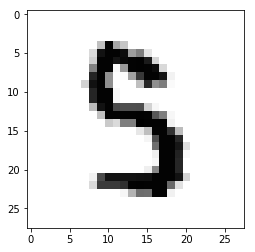

In [12]:
plt.imshow(images[0].reshape(28, 28), cmap="Greys");

## Train the Network

We train the network by passing the generator, `g`, to the model's fit function. In Keras, if a generator is used we used the `fit_generator()` function as opposed to the standard `fit()` function. Also, the steps per epoch should roughly equal the total number of images in your dataset divided by the `batch_size`.

Training the network over 5 epochs, we get the following output:

In [13]:
h = model.fit_generator(g, steps_per_epoch=len(p.augmentor_images)/batch_size, epochs=5, verbose=1)

Epoch 1/5
468/468 [==============================] - 30s 65ms/step - loss: 0.4860 - acc: 0.8478
Epoch 2/5
468/468 [==============================] - 29s 63ms/step - loss: 0.2026 - acc: 0.9392
Epoch 3/5
468/468 [==============================] - 29s 61ms/step - loss: 0.1611 - acc: 0.9523
Epoch 4/5
468/468 [==============================] - 28s 60ms/step - loss: 0.1405 - acc: 0.9582
Epoch 5/5
468/468 [==============================] - 28s 59ms/step - loss: 0.1203 - acc: 0.9645


## Summary

Using Augmentor with Keras means only that you need to create a generator when you are finished creating your pipeline. This has the advantage that no images need to be saved to disk and are augmented on the fly.